# 🔍 Visual Product Recommender (FAISS + DINO)

Upload or specify an image, embed it using DINO, and retrieve top-K similar product images with FAISS.

In [2]:
pip install numpy pandas matplotlib torch torchvision timm faiss-cpu pillow jupyter


  Using cached timm-1.0.16-py3-none-any.whl.metadata (57 kB)
  Using cached safetensors-0.5.3-cp38-abi3-win_amd64.whl.metadata (3.9 kB)
Using cached timm-1.0.16-py3-none-any.whl (2.5 MB)
Using cached safetensors-0.5.3-cp38-abi3-win_amd64.whl (308 kB)

   ------------- -------------------------- 1/3 [huggingface_hub]
   ------------- -------------------------- 1/3 [huggingface_hub]
   ------------- -------------------------- 1/3 [huggingface_hub]
   ------------- -------------------------- 1/3 [huggingface_hub]
   ------------- -------------------------- 1/3 [huggingface_hub]
   ------------- -------------------------- 1/3 [huggingface_hub]
   ------------- -------------------------- 1/3 [huggingface_hub]
   ------------- -------------------------- 1/3 [huggingface_hub]
   -------------------------- ------------- 2/3 [timm]
   -------------------------- ------------- 2/3 [timm]
   -------------------------- ------------- 2/3 [timm]
   -------------------------- ------------- 2/3 [timm]


In [1]:
import os
import json

import numpy as np
import pandas as pd
import torch, timm, faiss
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

In [2]:
# Load resources
with open("C:/Users/mishs/Downloads/VisualProductRecommendor/embeddings/image_paths.json") as f:
    image_paths = json.load(f)

metadata = pd.read_csv("C:/Users/mishs/Downloads/VisualProductRecommendor/data/metadata.csv")
embeddings = np.load("C:/Users/mishs/Downloads/VisualProductRecommendor/embeddings/dino_aug_embeddings.npy").astype("float32")
index = faiss.read_index("C:/Users/mishs/Downloads/VisualProductRecommendor/embeddings/all_embeddings_index.faiss")


In [3]:
# === Load DINOv2 model and preprocessing ===
device = "cuda" if torch.cuda.is_available() else "cpu"
model = timm.create_model("vit_base_patch14_dinov2.lvd142m", pretrained=True)
model.head = torch.nn.Identity()  # remove classification head
model.eval().to(device)

transform = transforms.Compose([
    transforms.Resize((518, 518)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

def embed_query_image(img_path):
    img = Image.open(img_path).convert("RGB")
    tensor = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        vec = model(tensor)
    vec = vec.cpu().numpy()
    vec /= np.linalg.norm(vec)  # normalize for cosine similarity
    return vec.astype("float32")


In [4]:
# Provide path to query image
query_path = "C:/Users/mishs/Downloads/VisualProductRecommendor/data/mvtec_ad/transistor/train/good/001.png"
  # change this
query_vec = embed_query_image(query_path)
D, I = index.search(query_vec, 5)

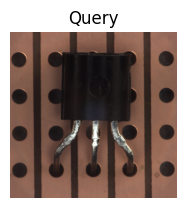

In [5]:
# ✅ Visualize query and results (absolute-safe version)

plt.figure(figsize=(15, 4))

# Show the query image
plt.subplot(1, 6, 1)
plt.imshow(Image.open(query_path))
plt.axis("off")
plt.title("Query")

# Loop over top FAISS matches
for i, idx in enumerate(I[0]):
    # Convert FAISS path to absolute
    raw_path = image_paths[idx]
    path = os.path.abspath(raw_path)

    # Match metadata based on normalized absolute path
    meta = metadata[metadata['path'].apply(lambda x: os.path.normpath(os.path.abspath(x))) == os.path.normpath(path)]

    # Title with metadata
    title = "No match"
    if not meta.empty:
        cat = meta.iloc[0]["category"]
        title = f"{cat}\nSim: {D[0][i]:.2f}"

    # Display image if it exists
    if os.path.exists(path):
        img = Image.open(path)
        plt.s


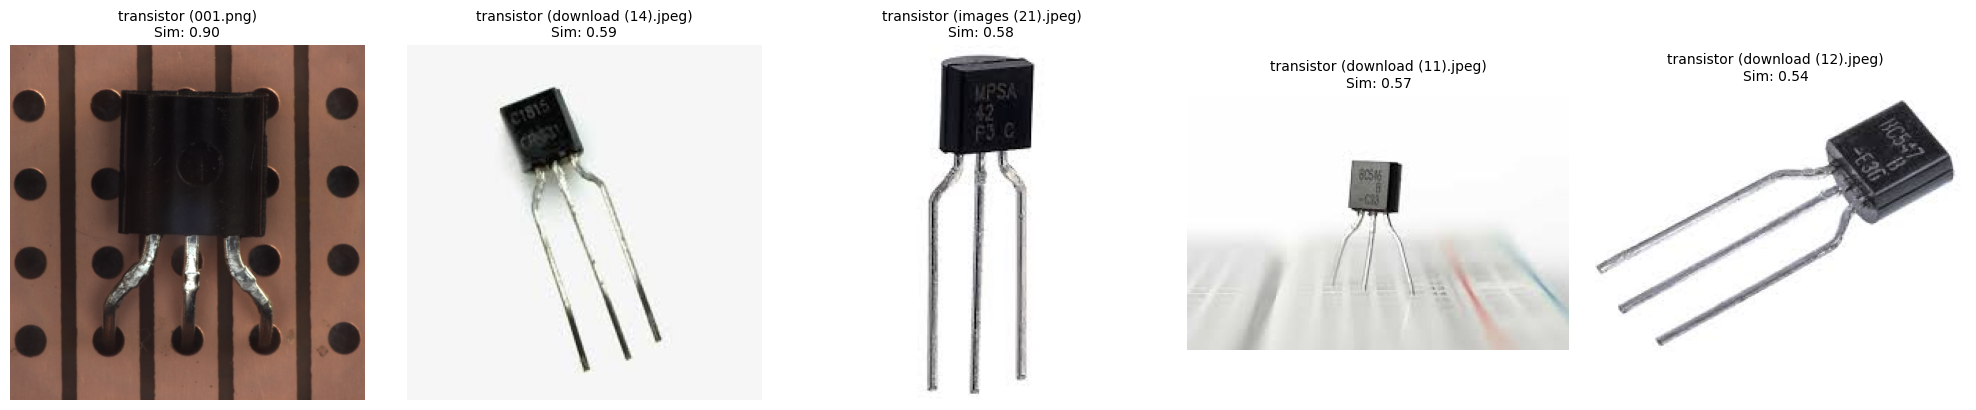

In [6]:
# ✅ Display only top-5 matched result images (with correct absolute paths)

project_root = "C:/Users/mishs/Downloads/VisualProductRecommendor"
TOP_K = 5
plt.figure(figsize=(4 * TOP_K, 4))

for i, idx in enumerate(I[0][:TOP_K]):
    raw_path = image_paths[idx]
    path = os.path.normpath(os.path.join(project_root, raw_path))

    # Get metadata row
    meta = metadata[metadata['path'].apply(lambda x: os.path.normpath(os.path.join(project_root, x))) == path]

    title = "No match"
    if not meta.empty:
        cat = meta.iloc[0]["category"]
        name = os.path.basename(path)
        title = f"{cat} ({name})\nSim: {D[0][i]:.2f}"

    # Plot image
    if os.path.exists(path):
        img = Image.open(path)
        plt.subplot(1, TOP_K, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(title, fontsize=10)
    else:
        print(f"❌ Missing: {path}")

plt.tight_layout()
plt.show()

    # Show image
    

